# Machine Learning for Asset Managers

Marcos M. López de Prado
Cornell University
Author for correspondence: ml863@cornell.edu

Abstract: Successful investment strategies are specific implementations of
general theories. An investment strategy that lacks a theoretical
justification is likely to be false. Hence, an asset manager should
concentrate her efforts on developing a theory rather than on backtesting
potential trading rules. The purpose of this Element is to introduce
machine learning (ML) tools that can help asset managers discover
economic and financial theories. ML is not a black box, and it does not
necessarily overfit. ML tools complement rather than replace the classical
statisticalmethods. Some ofML’s strengths include: (1) a focus on out-ofsample
predictability instead of in-sample variance adjudication; (2) the
use of computationalmethods to avoid relying on (potentially unrealistic)
assumptions; (3) the ability to “learn” complex specifications, including
nonlinear, hierarchical, and noncontinuous interaction effects in a highdimensional
space; and (4) the ability to disentangle the variable search
from the specification search, in a manner that is robust to
multicollinearity and other substitution effects.

## CHAPTER 2 - 2 Denoising and Detoning
#### SNIPPET 2.1 THE MARCENKO–PASTUR PDF

In [1]:
import numpy as np,pandas as pd
#---------------------------------------------------
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

#### SNIPPET 2.2 TESTING THE MARCENKO–PASTUR THEOREM

In [3]:
from sklearn.neighbors.kde import KernelDensity
#---------------------------------------------------
def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec
#---------------------------------------------------
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf
#---------------------------------------------------
x=np.random.normal(size=(10000,1000))
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=0))
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000)
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf

#### SNIPPET 2.3 ADD SIGNAL TO A RANDOM COVARIANCE MATRIX

In [4]:
def getRndCov(nCols,nFacts):
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) # random cov matrix, however not full rank
    cov+=np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov
#---------------------------------------------------
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#---------------------------------------------------
alpha,nCols,nFact,q=.995,1000,100,10
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0)
cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal
corr0=cov2corr(cov)
eVal0,eVec0=getPCA(corr0)

#### SNIPPET 2.4 FITTING THE MARCENKO–PASTUR PDF

In [7]:
from scipy.optimize import minimize
#---------------------------------------------------
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse
#---------------------------------------------------
def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),
        bounds=((1E-5,1-1E-5),))
    if out['success']:var=out['x'][0]
    else:var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var
#---------------------------------------------------
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01)
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

Exception: Data must be 1-dimensional

#### SNIPPET 2.5 DENOISING BY CONSTANT RESIDUAL EIGENVALUE

In [8]:
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1
#---------------------------------------------------
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

NameError: name 'nFacts0' is not defined

#### SNIPPET 2.6 DENOISING BY TARGETED SHRINKAGE

In [9]:
def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
    # Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
    return corr2
#---------------------------------------------------
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5)
eVal1,eVec1=getPCA(corr1)

NameError: name 'nFacts0' is not defined

#### SNIPPET 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS

In [10]:
def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#---------------------------------------------------
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
#---------------------------------------------------
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

NameError: name 'corr2cov' is not defined

#### SNIPPET 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX

In [11]:
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1

#### SNIPPET 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX

In [12]:
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#---------------------------------------------------
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

#### SNIPPET 2.10 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX

In [68]:
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w
#---------------------------------------------------
nObs,nTrials,bWidth,shrink,minVarPortf=1000,1000,.01,False,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),
        index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth)
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

Exception: Data must be 1-dimensional

#### SNIPPET 2.11 ROOT-MEAN-SQUARE ERRORS

In [16]:
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(rmsd,rmsd_d)

NameError: name 'cov0' is not defined

## CHAPTER 3 - Distance Metrics
#### SNIPPET 3.1 MARGINAL, JOINT, CONDITIONAL ENTROPIES, AND MUTUAL INFORMATION

In [17]:
import numpy as np,scipy.stats as ss
from sklearn.metrics import mutual_info_score
cXY=np.histogram2d(x,y,bins)[0]
hX=ss.entropy(np.histogram(x,bins)[0]) # marginal
hY=ss.entropy(np.histogram(y,bins)[0]) # marginal
iXY=mutual_info_score(None,None,contingency=cXY)
iXYn=iXY/min(hX,hY) # normalized mutual information
hXY=hX+hY-iXY # joint
hX_Y=hXY-hY # conditional
hY_X=hXY-hX # conditional

NameError: name 'y' is not defined

#### SNIPPET 3.2 MUTUAL INFORMATION, VARIATION OF INFORMATION, AND NORMALIZED VARIATION OF INFORMATION

In [18]:
import numpy as np,scipy.stats as ss
from sklearn.metrics import mutual_info_score
#---------------------------------------------------
def varInfo(x,y,bins,norm=False):
    # variation of information
    cXY=np.histogram2d(x,y,bins)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bins)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bins)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

#### SNIPPET 3.3 VARIATION OF INFORMATION ON DISCRETIZED CONTINUOUS RANDOM VARIABLES

In [19]:
def numBins(nObs,corr=None):
    # Optimal number of bins for discretization
    if corr is None: # univariate case
        z=(8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b=round(z/6.+2./(3*z)+1./3)
    else: # bivariate case
        b=round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    return int(b)
#---------------------------------------------------
def varInfo(x,y,norm=False):
    # variation of information
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
    hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
    vXY=hX+hY-2*iXY # variation of information
    if norm:
        hXY=hX+hY-iXY # joint
        vXY/=hXY # normalized variation of information
    return vXY

#### SNIPPET 3.4 CORRELATION AND NORMALIZED MUTUAL INFORMATION OF TWO INDEPENDENT GAUSSIAN RANDOM VARIABLES

In [20]:
def mutualInfo(x,y,norm=False):
    # mutual information
    bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
    cXY=np.histogram2d(x,y,bXY)[0]
    iXY=mutual_info_score(None,None,contingency=cXY)
    if norm:
        hX=ss.entropy(np.histogram(x,bXY)[0]) # marginal
        hY=ss.entropy(np.histogram(y,bXY)[0]) # marginal
        iXY/=min(hX,hY) # normalized mutual information
    return iXY
#---------------------------------------------------
size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
y=0*x+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]

## CHAPTER 4 - Optimal Clustering
#### SNIPPET 4.1 BASE CLUSTERING

In [64]:
import numpy as np,pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
#---------------------------------------------------
def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
    x,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series()# observations matrix
    for init in range(n_init):
        for i in range(2,maxNumClusters+1):
            kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1)
            kmeans_=kmeans_.fit(x)
            silh_=silhouette_samples(x,kmeans_.labels_)
            stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0]>stat[1]:
                silh,kmeans=silh_,kmeans_
    newIdx=np.argsort(kmeans.labels_)
    corr1=corr0.iloc[newIdx] # reorder rows
    corr1=corr1.iloc[:,newIdx] # reorder columns
    clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() \
        for i in np.unique(kmeans.labels_) } # cluster members
    silh=pd.Series(silh,index=x.index)
    return corr1,clstrs,silh

#### SNIPPET 4.2 TOP-LEVEL OF CLUSTERING

In [65]:
from sklearn.metrics import silhouette_samples
#---------------------------------------------------
def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew={}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    newIdx=[j for i in clstrsNew for j in clstrsNew[i]]
    corrNew=corr0.loc[newIdx,newIdx]
    x=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs=[x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(x,kmeans_labels),
        index=x.index)
    return corrNew,clstrsNew,silhNew
#---------------------------------------------------
def clusterKMeansTop(corr0,maxNumClusters=None,n_init=10):
    if maxNumClusters==None:maxNumClusters=corr0.shape[1]-1
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters= \
        min(maxNumClusters,corr0.shape[1]-1),n_init=n_init)
    clusterTstats={i:np.mean(silh[clstrs[i]])/ \
        np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=sum(clusterTstats.values())/len(clusterTstats)
    redoClusters=[i for i in clusterTstats.keys() if \
        clusterTstats[i]<tStatMean]
    if len(redoClusters)<=1:
        return corr1,clstrs,silh
    else:
        keysRedo=[j for i in redoClusters for j in clstrs[i]]
        corrTmp=corr0.loc[keysRedo,keysRedo]
        tStatMean=np.mean([clusterTstats[i] for i in redoClusters])
        corr2,clstrs2,silh2=clusterKMeansTop(corrTmp, \
            maxNumClusters=min(maxNumClusters, \
            corrTmp.shape[1]-1),n_init=n_init)
        # Make new outputs, if necessary
        corrNew,clstrsNew,silhNew=makeNewOutputs(corr0, \
            {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}, \
            clstrs2)
        newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/ \
            np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean<=tStatMean:
            return corr1,clstrs,silh
        else:
            return corrNew,clstrsNew,silhNew

#### SNIPPET 4.3 RANDOM BLOCK CORRELATION MATRIX CREATION

In [66]:
import numpy as np,pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
#---------------------------------------------------
def getCovSub(nObs,nCols,sigma,random_state=None):
    # Sub correl matrix
    rng=check_random_state(random_state)
    if nCols==1:return np.ones((1,1))
    ar0=rng.normal(size=(nObs,1))
    ar0=np.repeat(ar0,nCols,axis=1)
    ar0+=rng.normal(scale=sigma,size=ar0.shape)
    ar0=np.cov(ar0,rowvar=False)
    return ar0
#---------------------------------------------------
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,
    random_state=None):
    # Generate a block random correlation matrix
    rng=check_random_state(random_state)
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks), \
        nBlocks-1,replace=False)
    parts.sort()
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)
    parts=np.append(parts[0],np.diff(parts))-1+minBlockSize
    cov=None
    for nCols_ in parts:
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)), \
            nCols_,sigma,random_state=rng)
        if cov is None:cov=cov_.copy()
        else:cov=block_diag(cov,cov_)
    return cov
#---------------------------------------------------
def randomBlockCorr(nCols,nBlocks,random_state=None,
        minBlockSize=1):
    # Form block corr
    rng=check_random_state(random_state)
    cov0=getRndBlockCov(nCols,nBlocks,
        minBlockSize=minBlockSize,sigma=.5,random_state=rng)
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,
        sigma=1.,random_state=rng) # add noise
    cov0+=cov1
    corr0=cov2corr(cov0)
    corr0=pd.DataFrame(corr0)
    return corr0

## CHAPTER 5 - Financial Labels
#### SNIPPET 5.1 T-VALUE OF A LINEAR TREND

In [67]:
import statsmodels.api as sm1
#---------------------------------------------------
def tValLinR(close):
    # tValue from a linear trend
    x=np.ones((close.shape[0],2))
    x[:,1]=np.arange(close.shape[0])
    ols=sm1.OLS(close,x).fit()
    return ols.tvalues[1]

#### SNIPPET 5.2 IMPLEMENTATION OF THE TREND-SCANNING METHOD

In [33]:
def getBinsFromTrend(molecule,close,span):
    '''
    Derive labels from the sign of t-value of linear trend
    Output includes:
    - t1: End time for the identified trend
    - tVal: t-value associated with the estimated trend coefficient
    - bin: Sign of the trend
    '''
    out=pd.DataFrame(index=molecule,columns=['t1','tVal','bin'])
    hrzns=range(*span)
    for dt0 in molecule:
        df0=pd.Series()
        iloc0=close.index.get_loc(dt0)
        if iloc0+max(hrzns)>close.shape[0]:continue
        for hrzn in hrzns:
            dt1=close.index[iloc0+hrzn-1]
            df1=close.loc[dt0:dt1]
            df0.loc[dt1]=tValLinR(df1.values)
        dt1=df0.replace([-np.inf,np.inf,np.nan],0).abs().idxmax()
        out.loc[dt0,['t1','tVal','bin']]=df0.index[-1],df0[dt1],np.sign(df0[dt1]) # prevent leakage
        out['t1']=pd.to_datetime(out['t1'])
        out['bin']=pd.to_numeric(out['bin'],downcast='signed')
    return out.dropna(subset=['bin'])

#### SNIPPET 5.3 TESTING THE TREND-SCANNING LABELING ALGORITHM

In [34]:
df0=pd.Series(np.random.normal(0,.1,100)).cumsum()
df0+=np.sin(np.linspace(0,10,df0.shape[0]))
df1=getBinsFromTrend(df0.index,df0,[3,10,1])
mpl.scatter(df1.index,df0.loc[df1.index].values,c=df1['bin'].values, cmap='viridis')
mpl.savefig('fig 5.1.png');mpl.clf();mpl.close()
mpl.scatter(df1.index,df0.loc[df1.index].values,c=c,cmap='viridis')

ValueError: mixed datetimes and integers in passed array

## CHAPTER 6 - Feature Importance Analysis
#### SNIPPET 6.1 GENERATING A SET OF INFORMED, REDUNDANT, AND NOISE EXPLANATORY VARIABLES

In [36]:
def getTestData(n_features=100,n_informative=25,n_redundant=25,
    n_samples=10000,random_state=0,sigmaStd=.0):
    # generate a random dataset for a classification problem
    from sklearn.datasets import make_classification
    np.random.seed(random_state)
    X,y=make_classification(n_samples=n_samples,
        n_features=n_features-n_redundant,
        n_informative=n_informative,n_redundant=0,shuffle=False,
        random_state=random_state)
    cols=['I_'+str(i) for i in range(n_informative)]
    cols+=['N_'+str(i) for i in range(n_features-n_informative- \
        n_redundant)]
    X,y=pd.DataFrame(X,columns=cols),pd.Series(y)
    i=np.random.choice(range(n_informative),size=n_redundant)
    for k,j in enumerate(i):
        X['R_'+str(k)]=X['I_'+str(j)]+np.random.normal(size= \
            X.shape[0])*sigmaStd
    return X,y
#---------------------------------------------------
import numpy as np,pandas as pd,seaborn as sns
import statsmodels.discrete.discrete_model as sm
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
ols=sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


#### SNIPPET 6.2 IMPLEMENTATION OF AN ENSEMBLE MDI METHOD

In [37]:
def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in \
        enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),
        'std':df0.std()*df0.shape[0]**-.5},axis=1) # CLT
    imp/=imp['mean'].sum()
    return imp
#---------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
    class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
    max_features=1.,max_samples=1.,oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI(fit,featNames=X.columns)

#### SNIPPET 6.3 IMPLEMENTATION OF MDA

In [39]:
def featImpMDA(clf,X,y,n_splits=10):
    # feat importance based on OOS score reduction
    from sklearn.metrics import log_loss
    from sklearn.model_selection._split import KFold
    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0) # the fit occurs here
        prob=fit.predict_proba(X1) # prediction before shuffling
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # shuffle one column
            prob=fit.predict_proba(X1_) # prediction after shuffling
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),
    'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT
    return imp
#---------------------------------------------------
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
    class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
    max_features=1.,max_samples=1.,oob_score=False)
imp=featImpMDA(clf,X,y,10)

#### SNIPPET 6.4 CLUSTERED MDI

In [40]:
def groupMeanStd(df0,clstrs):
    out=pd.DataFrame(columns=['mean','std'])
    for i,j in clstrs.iteritems():
        df1=df0[j].sum(axis=1)
        out.loc['C_'+str(i),'mean']=df1.mean()
        out.loc['C_'+str(i),'std']=df1.std()*df1.shape[0]**-.5
    return out
#---------------------------------------------------
def featImpMDI_Clustered(fit,featNames,clstrs):
    df0={i:tree.feature_importances_ for i,tree in \
        enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=groupMeanStd(df0,clstrs)
    imp/=imp['mean'].sum()
    return imp

#### SNIPPET 6.5 CLUSTERED MDA

In [53]:
def featImpMDA_Clustered(clf,X,y,clstrs,n_splits=10):
    from sklearn.metrics import log_loss
    from sklearn.model_selection._split import KFold
    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=clstrs.keys())
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0)
        prob=fit.predict_proba(X1)
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in scr1.columns:
            X1_=X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) # shuffle cluster
            prob=fit.predict_proba(X1_)
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),
        'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index=['C_'+str(i) for i in imp.index]
    return imp

#### SNIPPET 6.6 FEATURES CLUSTERING STEP

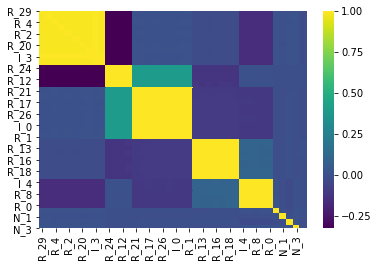

In [69]:
X,y=getTestData(40,5,30,10000,sigmaStd=.1)
corr0,clstrs,silh=clusterKMeansBase(X.corr(),maxNumClusters=10,
    n_init=10)
sns.heatmap(corr0,cmap='viridis')

#### SNIPPET 6.7 CALLING THE FUNCTIONS FOR CLUSTERED MDI

In [ ]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
    class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
    max_features=1.,max_samples=1.,oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI_Clustered(fit,X.columns,clstrs)

#### SNIPPET 6.8 CALLING THE FUNCTIONS FOR CLUSTERED MDA

In [ ]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
    class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
    max_features=1.,max_samples=1.,oob_score=False)
imp=featImpMDA_Clustered(clf,X,y,clstrs,10)

## CHAPTER 7 - Portfolio Construction
#### SNIPPET 7.1 COMPOSITION OF BLOCK-DIAGONAL CORRELATION MATRICES

3.0


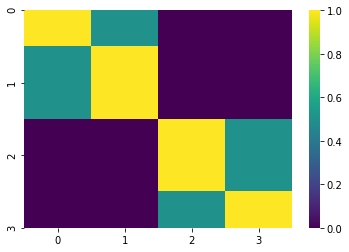

In [43]:
import matplotlib.pyplot as mpl,seaborn as sns
import numpy as np
#---------------------------------------------------
corr0=formBlockMatrix(2,2,.5)
eVal,eVec=np.linalg.eigh(corr0)
print(max(eVal)/min(eVal))
sns.heatmap(corr0,cmap='viridis')

#### SNIPPET 7.2 BLOCK-DIAGONAL CORRELATION MATRIX WITH A DOMINANT BLOCK

In [45]:
corr0=block_diag(formBlockMatrix(1,2,.5))
corr1=formBlockMatrix(1,2,.0)
corr0=block_diag(corr0,corr1)
eVal,eVec=np.linalg.eigh(corr0)
print(max(eVal)/min(eVal))

3.0


#### SNIPPET 7.3 THE CORRELATION CLUSTERING STEP

In [46]:
import pandas as pd
cols=cov0.columns
cov1=deNoiseCov(cov0,q,bWidth=.01) # de-noise cov
cov1=pd.DataFrame(cov1,index=cols,columns=cols)
corr1=cov2corr(cov1)
corr1,clstrs,silh=clusterKMeansBase(corr1,
    maxNumClusters=corr0.shape[0]/2,n_init=10)

NameError: name 'cov0' is not defined

#### SNIPPET 7.4 INTRACLUSTER OPTIMAL ALLOCATIONS

In [48]:
wIntra=pd.DataFrame(0,index=cov1.index,columns=clstrs.keys())
for i in clstrs:
    wIntra.loc[clstrs[i],i]=minVarPort(cov1.loc[clstrs[i],
        clstrs[i]]).flatten()
cov2=wIntra.T.dot(np.dot(cov1,wIntra)) # reduced covariance matrix

NameError: name 'cov1' is not defined

#### SNIPPET 7.5 INTERCLUSTER OPTIMAL ALLOCATIONS

In [49]:
wInter=pd.Series(minVarPort(cov2).flatten(),index=cov2.index)
wAll0=wIntra.mul(wInter,axis=1).sum(axis=1).sort_index()

NameError: name 'minVarPort' is not defined

#### SNIPPET 7.6 FUNCTION IMPLEMENTING THE NCO ALGORITHM

In [50]:
def optPort_nco(cov,mu=None,maxNumClusters=None):
    cov=pd.DataFrame(cov)
    if mu is not None:mu=pd.Series(mu[:,0])
    corr1=cov2corr(cov)
    corr1,clstrs,_=clusterKMeansBase(corr1,maxNumClusters,
        n_init=10)
    wIntra=pd.DataFrame(0,index=cov.index,columns=clstrs.keys())
    for i in clstrs:
        cov_=cov.loc[clstrs[i],clstrs[i]].values
        if mu is None:mu_=None
        else:mu_=mu.loc[clstrs[i]].values.reshape(-1,1)
        wIntra.loc[clstrs[i],i]=optPort(cov_,mu_).flatten()
    cov_=wIntra.T.dot(np.dot(cov,wIntra)) # reduce covariance matrix
    mu_=(None if mu is None else wIntra.T.dot(mu))
    wInter=pd.Series(optPort(cov_,mu_).flatten(),index=cov_.index)
    nco=wIntra.mul(wInter,axis=1).sum(axis=1).values.reshape(-1,1)
    return nco

#### SNIPPET 7.7 DATA-GENERATING PROCESS

In [51]:
nBlocks,bSize,bCorr =10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

#### SNIPPET 7.8 DRAWING AN EMPIRICAL VECTOR OF MEANS AND COVARIANCE MATRIX

In [55]:
nObs,nSims,shrink,minVarPortf=1000,1000,False,True
np.random.seed(0)
for i in range(nSims):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort_nco(cov1,mu1,
        int(cov1.shape[0]/2)).flatten()

NameError: name 'w1' is not defined

#### SNIPPET 7.9 ESTIMATION OF ALLOCATION ERRORS

In [56]:
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0) # true allocation
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE

NameError: name 'w1' is not defined

#### SNIPPET 8.1 EXPERIMENTAL VALIDATION OF THE FALSE STRATEGY THEOREM

In [60]:
import numpy as np,pandas as pd
from scipy.stats import norm,percentileofscore
#---------------------------------------------------
def getExpectedMaxSR(nTrials,meanSR,stdSR):
    # Expected max SR, controlling for SBuMT
    emc=0.577215664901532860606512090082402431042159336
    sr0=(1-emc)*norm.ppf(1-1./nTrials)+ emc*norm.ppf(1-(nTrials*np.e)**-1)
    sr0=meanSR+stdSR*sr0
    return sr0
#---------------------------------------------------
def getDistMaxSR(nSims,nTrials,stdSR,meanSR):
    # Monte Carlo of max{SR} on nTrials, from nSims simulations
    rng=np.random.RandomState()
    out=pd.DataFrame()
    for nTrials_ in nTrials:
        #1) Simulated Sharpe ratios
        sr=pd.DataFrame(rng.randn(nSims,nTrials_))
        sr=sr.sub(sr.mean(axis=1),axis=0) # center
        sr=sr.div(sr.std(axis=1),axis=0) # scale
        sr=meanSR+sr*stdSR
        #2) Store output
        out_=sr.max(axis=1).to_frame('max{SR}')
        out_['nTrials']=nTrials_
        out=out.append(out_,ignore_index=True)
    return out
#---------------------------------------------------
if __name__=='__main__':
    nTrials=list(set(np.logspace(1,6,1000).astype(int)));nTrials.sort()
    sr0=pd.Series({i:getExpectedMaxSR(i,meanSR=0,stdSR=1) \
        for i in nTrials})
    sr1=getDistMaxSR(nSims=1E3,nTrials=nTrials,meanSR=0,
        stdSR=1)

TypeError: 'float' object cannot be interpreted as an integer

#### SNIPPET 8.2 MEAN AND STANDARD DEVIATION OF THE PREDICTION ERRORS

In [70]:
def getMeanStdError(nSims0,nSims1,nTrials,stdSR=1,meanSR=0):
    # Compute standard deviation of errors per nTrial
    # nTrials: [number of SR used to derive max{SR}]
    # nSims0: number of max{SR} used to estimate E[max{SR}]
    # nSims1: number of errors on which std is computed
    sr0=pd.Series({i:getExpectedMaxSR(i,meanSR,stdSR) \
        for i in nTrials})
    sr0=sr0.to_frame('E[max{SR}]')
    sr0.index.name='nTrials'
    err=pd.DataFrame()
    for i in range(int(nSims1)):
        sr1=getDistDSR(nSims=1E3,nTrials=nTrials,meanSR=0,
            stdSR=1)
        sr1=sr1.groupby('nTrials').mean()
        err_=sr0.join(sr1).reset_index()
        err_['err']=err_['max{SR}']/err_['E[max{SR}]']-1.
        err=err.append(err_)
    out={'meanErr':err.groupby('nTrials')['err'].mean()}
    out['stdErr']=err.groupby('nTrials')['err'].std()
    out=pd.DataFrame.from_dict(out,orient='columns')
    return out
#---------------------------------------------------
if __name__=='__main__':
    nTrials=list(set(np.logspace(1,6,1000).astype(int)));nTrials.sort()
    stats=getMeanStdError(nSims0=1E3,nSims1=1E2,
        nTrials=nTrials,stdSR=1)

NameError: name 'getDistDSR' is not defined

#### SNIPPET 8.3 TYPE I ERROR, WITH NUMERICAL EXAMPLE

In [72]:
import scipy.stats as ss
#---------------------------------------------------
def getZStat(sr,t,sr_=0,skew=0,kurt=3):
    z=(sr-sr_)*(t-1)**.5
    z/=(1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return z
#---------------------------------------------------
def type1Err(z,k=1):
    # false positive rate
    alpha=ss.norm.cdf(-z)
    alpha_k=1-(1-alpha)**k # multi-testing correction
    return alpha_k
#---------------------------------------------------
def main0():
    # Numerical example
    t,skew,kurt,k,freq=1250,-3,10,10,250
    sr=1.25/freq**.5;sr_=1./freq**.5
    z=getZStat(sr,t,0,skew,kurt)
    alpha_k=type1Err(z,k=k)
    print(alpha_k)
    return
#---------------------------------------------------
if __name__=='__main__':main0()

0.060760769078662125


#### SNIPPET 8.4 TYPE II ERROR, WITH NUMERICAL EXAMPLE

In [74]:
def getTheta(sr,t,sr_=0,skew=0,kurt=3):
    theta=sr_*(t-1)**.5
    theta/=(1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return theta
#---------------------------------------------------
def type2Err(alpha_k,k,theta):
    # false negative rate
    z=ss.norm.ppf((1-alpha_k)**(1./k)) # Sidak’s correction
    beta=ss.norm.cdf(z-theta)
    return beta
#---------------------------------------------------
def main0():
    # Numerical example
    t,skew,kurt,k,freq=1250,-3,10,10,250
    sr=1.25/freq**.5;sr_=1./freq**.5
    z=getZStat(sr,t,0,skew,kurt)
    alpha_k=type1Err(z,k=k)
    theta=getTheta(sr,t,sr_,skew,kurt)
    beta=type2Err(alpha_k,k,theta)
    beta_k=beta**k
    print(beta_k)
    return
#---------------------------------------------------
if __name__=='__main__':main0()

0.024928646400445776
